Random Forest Analysis

In [8]:
import glob
import matplotlib.pyplot as plt
import tifffile as tf
import numpy as np
import time
import functions

start_time = time.time()

MainFolder = "/kaggle/input/eq-maras"
Features = glob.glob(MainFolder + "/Features/**/*.tif" , recursive=True) # include subfolders recursive=True
InventoryPath= glob.glob(MainFolder + "/Inventory/*.tif")
DEMFile = MainFolder + "/Features/DEM/EU_DEM.tif"
ResultFile = MainFolder + "/Result/Result_1ls-15nonls-Best-EU25m.tif"

In [9]:
print ("\r\nEgitim ve test verileri olusturuluyor...\r\n")
X_train, X_test, y_train, y_test = functions.FeatureSet.CreateTrainAndTestData(Features, InventoryPath, 1, 0.2, 1.5)
# %store X_train, y_train # For sharing variables between different jupyter notebooks
# np.savez_compressed('Xy_train.npz',x=X_train,y=y_train)


Egitim ve test verileri olusturuluyor...

Egitim verisi için Inventory secildi.
15 adet feature okundu.
594413 piksel envanter verisi mevcut, 
594413 adet piksel egitim verisi (1) olarak kullanildi.
891619 adet piksel egitim verisi (0) olarak kullanildi.


In [10]:
def Predict(X, y, X_test):
    from sklearn.ensemble import RandomForestClassifier
    Classifier=RandomForestClassifier(n_estimators=344,criterion='entropy',max_depth=38,min_samples_split=2,min_samples_leaf=2,class_weight='balanced',bootstrap=True,random_state=32,oob_score=True,n_jobs=-1,max_features='auto')
    #Classifier=RandomForestClassifier(n_estimators=50,criterion='entropy',max_depth=16,min_samples_split=2,min_samples_leaf=4,class_weight='balanced',bootstrap=True,random_state=32,oob_score=True,n_jobs=-1)
    Classifier.fit(X, y)
    y_pred=Classifier.predict(X_test)
    return Classifier, y_pred

print ("RF regression basladi...\r\n")
RFClassifier, y_pred = Predict(X_train, y_train.ravel(), X_test)

RF regression basladi...



In [11]:
RFClassifier

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=38, min_samples_leaf=2, n_estimators=344,
                       n_jobs=-1, oob_score=True, random_state=32)

In [12]:
import joblib
# Save model to file
joblib.dump(RFClassifier, '/kaggle/working/RF_LS_Model.pkl')
# Load model from file
# RFClassifier = joblib.load(MainFolder + '/Study/Model/RF_LS_Model.pkl')

['/kaggle/working/RF_LS_Model.pkl']

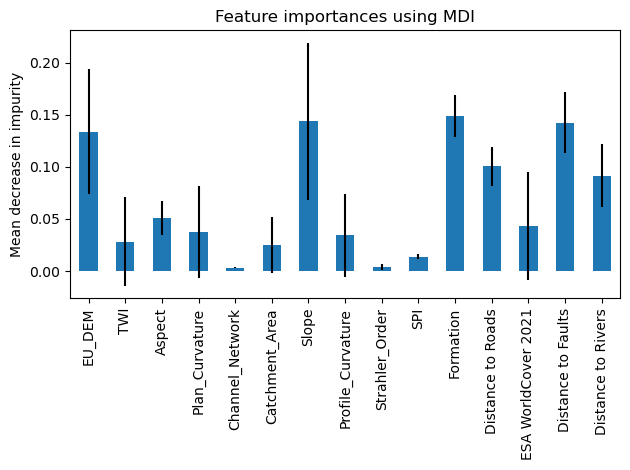

In [14]:
def ShowImportances(MainFolder, Features, RFClassifier):
    importances = RFClassifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in RFClassifier.estimators_], axis=0)
    from pathlib import Path
    feature_names = [Path(feature).stem for feature in Features]
    import pandas as pd
    FeatureImportances = pd.Series(importances, index=feature_names)
    fig, ax = plt.subplots()
    FeatureImportances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    # fig.set_size_inches (10,15)
    fig.tight_layout()
    # fig.show()
    fig.savefig("Feature_Importance", dpi = 600)

ShowImportances(MainFolder, Features, RFClassifier)

Confusion Matrix
 [[173902   4385]
 [  3280 115640]] 

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    178287
           1       0.96      0.97      0.97    118920

    accuracy                           0.97    297207
   macro avg       0.97      0.97      0.97    297207
weighted avg       0.97      0.97      0.97    297207


Accuracy: 0.9742


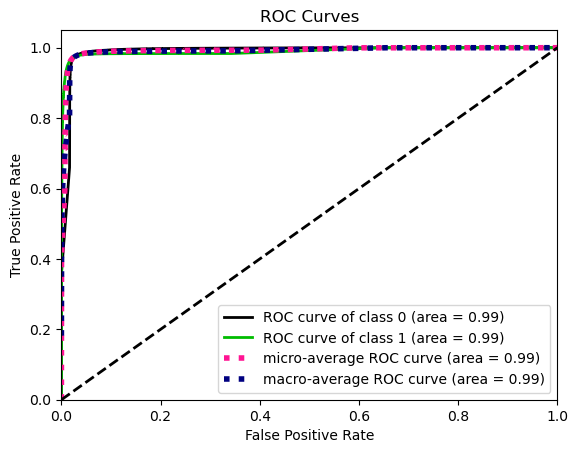

Area Under Curve: 0.9898


<Figure size 640x480 with 0 Axes>

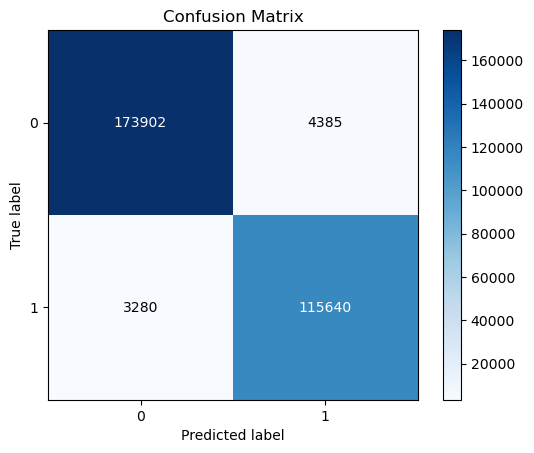

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,roc_curve
import scikitplot as skplt

cm=confusion_matrix(y_test, y_pred)
print("Confusion Matrix\r\n",cm,"\r\n")
print("Classification Report")
print(classification_report(y_test, y_pred) + "\r\n")
print("Accuracy: {:.4f}".format(metrics.accuracy_score(y_test, y_pred)))

probs = RFClassifier.predict_proba(X_test)
skplt.metrics.plot_roc(y_test,probs)
plt.show()
plt.savefig("RF_ROC", dpi = 600)

print("Area Under Curve: {:.4f}".format(metrics.roc_auc_score(y_test,probs[:, 1])))

skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=False)
plt.show()
plt.savefig("RF_CM", dpi = 600)

In [ ]:
# regr = RandomForestRegressor(max_depth=2, random_state=0)
# regr.fit(X_train_s, y_train_s.ravel())
# y_pred_s=regr.predict(X_test_s)

In [ ]:
Classes = [] 
for feature in Features:
    cache = functions.Feature(feature).image.flatten()
    cache[np.isnan(cache)]=0
    Classes.append(cache.T)
Classes = np.asarray(Classes)

In [3]:
import joblib
# Load model from file
RFClassifier = joblib.load('/kaggle/working/RF_LS_Model.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/RF_LS_Model.pkl'

In [4]:
#from numba import jit, cuda
#@jit(target_backend='cuda')
def new_func():
    PredictClassProbabilities = RFClassifier.predict_proba(Classes.T)[:,1]
new_func()

NameError: name 'RFClassifier' is not defined

In [ ]:
cols, rows = functions.FeatureSet.Dimensions(DEMFile)
# no_datas = np.where(np.isnan(tf.imread(DEMFile).flatten())) 
no_datas = np.where(tf.imread(DEMFile).flatten()<-9998)
PredictClassProbabilities[no_datas]=-9999
data = PredictClassProbabilities.reshape(rows,cols)

import matplotlib.pyplot as plt
plt.style.use('default')
plt.imshow(data, cmap=plt.cm.viridis)
plt.colorbar()
plt.savefig("RF-ROC_map", dpi = 600)

In [ ]:
functions.FeatureSet.GeoExport(data, ResultFile, DEMFile, -9999)

In [ ]:
def PrintElapsedTime(start_time):
    from datetime import timedelta
    elapsed = time.time() - start_time
    td_str = str(timedelta(seconds=elapsed))
    x = td_str.split(':')
    print(f'{x[0]} saat {x[1]} dakika {x[2]} saniyede tamamlandı.')
PrintElapsedTime(start_time)